In [1]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split
import pickle

In [2]:
from numpy import loadtxt

In [7]:
# with open("../notebooks/airlines.txt") as f:
#     unique_airlines = f.readlines()
# # you may also want to remove whitespace characters like `\n` at the end of each line
# unique_airlines = [x.strip() for x in unique_airlines]

In [9]:
# f.close()

In [3]:
dat = pd.read_csv("../data/external/sample.csv")

dat = dat.iloc[:,2:]

dat = dat.dropna()

In [4]:
unique_airline = sorted(dat.OP_UNIQUE_CARRIER.unique().tolist())
unique_origin = sorted(dat.ORIGIN.unique().tolist())
unique_dest = sorted(dat.DEST.unique().tolist())

In [14]:
# with open('airlines.txt', 'w') as f:
#     for item in unique_airline:
#         f.write("%s\n" % item)
# with open('origin.txt', 'w') as f:
#     for item in unique_origin:
#         f.write("%s\n" % item)
# with open('dest.txt', 'w') as f:
#     for item in unique_dest:
#         f.write("%s\n" % item)

In [5]:
dat['dep_hour'] = np.where(dat['CRS_DEP_TIME'].astype('str').str.len() > 2, np.where(dat['CRS_DEP_TIME'].astype('str').str.len() == 3 ,'0' + dat['CRS_DEP_TIME'].astype('str').str.slice(0, -2), dat['CRS_DEP_TIME'].astype('str').str.slice(0, -2)), 0)

In [6]:
dat['length'] = dat['CRS_ELAPSED_TIME'] // 60

In [7]:
dat = pd.get_dummies(dat, columns = ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'dep_hour', 'OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST'])

In [8]:
dat = dat.drop(columns = ['ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'ARR_DELAY', 'ARR_TIME', 'DEP_TIME', 'CRS_DEP_TIME', 'CRS_ARR_TIME','CRS_ELAPSED_TIME'])

In [9]:
dat['delay'] = np.where(dat['DEP_DELAY']>0, 'delay', 'on_time')

In [10]:
dat = dat.drop(columns = ['DEP_DELAY'])

In [11]:
target = dat['delay']
features = dat.drop(columns = 'delay')

In [12]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

In [13]:
clf = tree.DecisionTreeClassifier(max_depth = 10)
clf = clf.fit(X_train, y_train)

In [16]:
predictions = clf.predict_proba(X_test)

In [17]:
predictions

array([[0.35683245, 0.64316755],
       [0.5476378 , 0.4523622 ],
       [0.39225017, 0.60774983],
       ...,
       [0.42120875, 0.57879125],
       [0.32238528, 0.67761472],
       [0.5476378 , 0.4523622 ]])

In [27]:
# decision_tree_pkl_filename = 'tree.pkl'
# # Open the file to save as pkl file
# decision_tree_model_pkl = open(decision_tree_pkl_filename, 'wb')
# pickle.dump(clf, decision_tree_model_pkl)
# # Close the pickle instances
# decision_tree_model_pkl.close()

In [15]:
sum(predictions == y_test) / len(y_test)

0.6686382393397524

In [25]:
y_train = [1 if i == 'on_time' else 0 for i in y_train]

In [27]:
y_test = [1 if i == 'on_time' else 0 for i in y_test]

In [51]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=200, random_state=0)
regressor.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [52]:
y_pred = regressor.predict(X_test)

In [54]:
y_pred = [1 if i > 0.5 else 0 for i in y_pred]

In [55]:
summ = 0
for i in range(len(y_pred)):
    if y_pred[i] == y_test[i]:
        summ = summ + 1

In [56]:
summ

9718

In [57]:
summ / len(y_test)

0.668363136176066

In [58]:
importance = regressor.feature_importances_
importance_df = pd.DataFrame(importance, index=X_train.columns, 
                      columns=["Importance"])

In [105]:
imp = importance_df.sort_values(by = 'Importance', ascending = False)[:20]

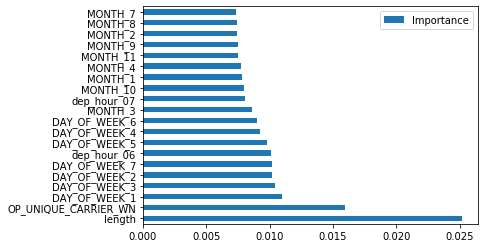

In [108]:
imp.plot.barh()

In [70]:
dat.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,delay
0,6,23,7,AS,EWR,SEA,600,558.0,-2.0,905,902.0,-3.0,365.0,364.0,338.0,2402.0,on_time
1,9,9,1,DL,MSP,ORD,1735,1751.0,16.0,1907,1913.0,6.0,92.0,82.0,52.0,334.0,delay
2,8,14,3,AA,CLT,DCA,1448,1442.0,-6.0,1623,1554.0,-29.0,95.0,72.0,51.0,331.0,on_time
3,4,27,6,DL,LAX,MSP,1255,1249.0,-6.0,1837,1801.0,-36.0,222.0,192.0,179.0,1535.0,on_time
4,1,24,4,DL,MSP,LAX,2058,2058.0,0.0,2310,2229.0,-41.0,252.0,211.0,191.0,1535.0,on_time


In [77]:
delay_count = dat.groupby('OP_UNIQUE_CARRIER').apply(lambda x: (x == 'delay').sum())['delay'].reset_index()

In [78]:
delay_count

,OP_UNIQUE_CARRIER,delay
0,9E,641
1,AA,3445
2,AS,840
3,B6,1088
4,DL,3031
5,EV,423
6,F9,519
7,G4,350
8,HA,236
9,MQ,915


In [79]:
count = dat.groupby('OP_UNIQUE_CARRIER').count()

In [81]:
count = count['MONTH']

In [83]:
count = count.reset_index()

In [84]:
count

,OP_UNIQUE_CARRIER,MONTH
0,9E,2484
1,AA,9101
2,AS,2567
3,B6,2843
4,DL,9963
5,EV,1311
6,F9,1330
7,G4,1077
8,HA,864
9,MQ,3099


In [110]:
df = count.merge(delay_count)

In [114]:
df

,OP_UNIQUE_CARRIER,MONTH,delay,perc_delayed
0,9E,2484,641,0.258052
1,AA,9101,3445,0.378530
2,AS,2567,840,0.327230
3,B6,2843,1088,0.382694
4,DL,9963,3031,0.304226
5,EV,1311,423,0.322654
6,F9,1330,519,0.390226
7,G4,1077,350,0.324977
8,HA,864,236,0.273148
9,MQ,3099,915,0.295257


In [112]:
df['perc_delayed'] = df['delay'] / df['MONTH']

In [100]:
df.index = df['OP_UNIQUE_CARRIER']

In [101]:
df.drop(columns = ['OP_UNIQUE_CARRIER'], inplace=True)

In [103]:
df.columns = ['ALL', 'DELAYED']

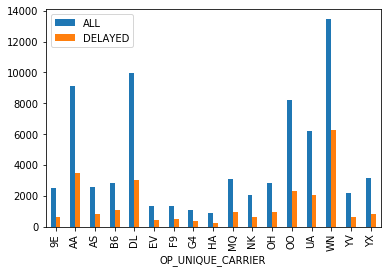

In [104]:
df.plot.bar()

In [116]:
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(y_test, y_pred)
print(CM)

[[1648 3349]
 [1473 8070]]


In [120]:
dat.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,delay
0,6,23,7,AS,EWR,SEA,600,558.0,-2.0,905,902.0,-3.0,365.0,364.0,338.0,2402.0,on_time
1,9,9,1,DL,MSP,ORD,1735,1751.0,16.0,1907,1913.0,6.0,92.0,82.0,52.0,334.0,delay
2,8,14,3,AA,CLT,DCA,1448,1442.0,-6.0,1623,1554.0,-29.0,95.0,72.0,51.0,331.0,on_time
3,4,27,6,DL,LAX,MSP,1255,1249.0,-6.0,1837,1801.0,-36.0,222.0,192.0,179.0,1535.0,on_time
4,1,24,4,DL,MSP,LAX,2058,2058.0,0.0,2310,2229.0,-41.0,252.0,211.0,191.0,1535.0,on_time


In [133]:
def f(x):
    return (x.delay == 'delay').sum() / x.count()

In [137]:
dow = dat.groupby('DAY_OF_WEEK').agg(f)['delay'].reset_index().sort_values(by = 'delay', ascending = False)

In [138]:
dow.index = dow['DAY_OF_WEEK']

In [142]:
dow.drop(columns = 'DAY_OF_WEEK', inplace = True)

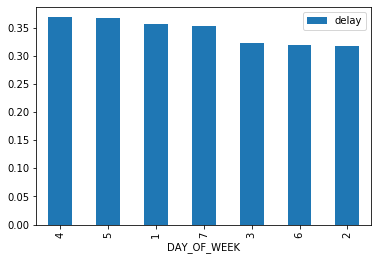

In [145]:
dow.plot.bar()

In [ ]:
dow.index = ['MONDAY']